In [38]:
!tar -czvf trained_models_cancer.tar.gz /content/trained_models_cancer

tar: Removing leading `/' from member names
/content/trained_models_cancer/
/content/trained_models_cancer/alex_net_model.keras
/content/trained_models_cancer/InceptionResNetV2_model.keras
/content/trained_models_cancer/Xception_model.keras
/content/trained_models_cancer/densenet_121_model.keras


In [39]:
# mount it
# from google.colab import drive
# drive.mount('/content/drive')
# copy it there
!cp trained_models_cancer.tar.gz /content/drive/MyDrive

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
!unzip melanoma-skin-cancer-dataset-of-10000-images.zip

In [27]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
#from constants import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Rescaling, Input, Resizing
from tensorflow.keras.applications import EfficientNetV2B3, InceptionResNetV2, DenseNet121, Xception
from keras.optimizers import Adam

In [2]:
DATA_PATH = "/content/data/"
TRAIN_DIR = DATA_PATH + "train"
TEST_DIR = DATA_PATH + "test"
SEED = 1234

## Load and Inspect Images

In [3]:
# Read an image to see image specs
img = cv2.imread(DATA_PATH +'train/benign/melanoma_0.jpg')
img.shape, img.min(), img.max()

((300, 300, 3), 26, 255)

In [4]:
batch_size = 32
train_gen = tf.keras.utils.image_dataset_from_directory(
            TRAIN_DIR,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(300, 300),
            shuffle=True,
            seed=SEED,
            interpolation='bilinear',
            crop_to_aspect_ratio=True,
        )

test_gen = tf.keras.utils.image_dataset_from_directory(
            TEST_DIR,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(300, 300),
            shuffle=True,
            seed=SEED,
            interpolation='bilinear',
            crop_to_aspect_ratio=True,
        )

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
# more image specs
for (x, y) in train_gen.take(10):
    print(x.shape, x[0][0].numpy().min(), x[0][0].numpy().max(), y.shape)
    break
print(x.numpy().min(), x.numpy().max())

(32, 300, 300, 3) 0.0 195.0 (32,)
0.0 255.0


In [18]:
def get_class_count(data_gen):
    # Get the class names from the dataset
    class_names = data_gen.class_names

    # Initialize a dictionary to store the counts of each class
    class_counts = {class_name: 0 for class_name in class_names}

    # Iterate through the dataset to count the occurrences of each class
    for images, labels in data_gen:
        for label in labels:
            class_name = class_names[label.numpy()]
            class_counts[class_name] += 1

    # Print the count of each class
    for class_name, count in class_counts.items():
        print(f'{class_name}: {count}')

# classes are closely balanced
get_class_count(train_gen)

benign: 5000
malignant: 4605


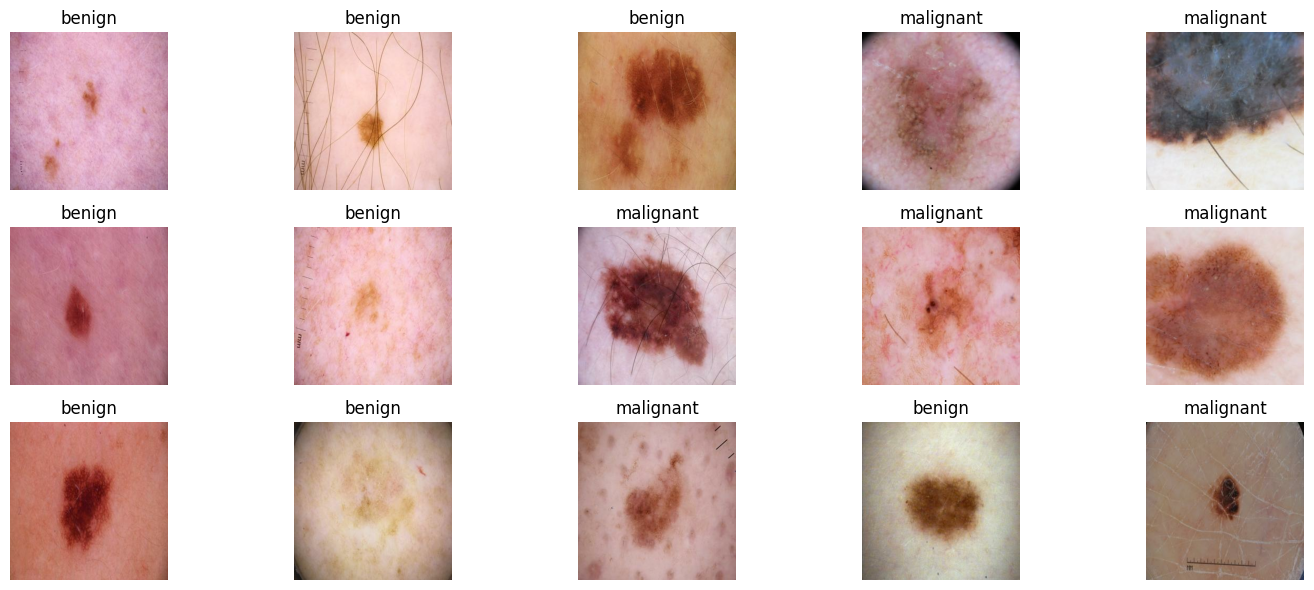

In [19]:
def plot_images(image_dataset):
    # Get the class names from the dataset
    class_names = image_dataset.class_names

    # Plot 10 subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 6))
    axs = axs.ravel()

    # Iterate through the dataset to plot images from different batches
    for i, (images, labels) in enumerate(image_dataset):
        if i == 15:  # Plot 15 batches (total of 320 images)
            break
        for image, label in zip(images, labels):
            class_name = class_names[label.numpy()]
            axs[i].imshow(image.numpy().astype('uint8'))
            axs[i].set_title(class_name)
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_images(train_gen)
# benign and malignant skin patches look similar although there are some differences
# malignant tend to have a darker color, the model will have to identify if not all most differences

### Notes

- Class are closely balanced:
    - benign: 5000
    - malignant: 4605

- Original images are relatively small, 300x300
    - Pre-trained models typically want images at around 225x225

- Train set has a relatively large number of images from each class, ignore image augmentation for now

## Models

In [31]:
def create_alexnet_model(input_shape, batch_size):
    model = Sequential([
        Input(shape=input_shape, batch_size=batch_size),
        Rescaling(1./255),
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(2096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # binary classification
    ])
    return model

In [32]:
batch_size = 32
epochs = 20
input_shape = (300, 300, 3)
lr=0.0001

In [33]:
alex_net = create_alexnet_model(input_shape, batch_size)

alex_net.compile(optimizer=Adam(lr),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_alex = alex_net.fit(train_gen,
                            batch_size=batch_size,
                            epochs=epochs,
                            shuffle=True,
                            validation_data=test_gen
)

alex_net.save('alex_net_model.keras')

Epoch 1/20
301/301 [==============================] - 36s 98ms/step - loss: 0.5674 - accuracy: 0.6788 - val_loss: 0.2977 - val_accuracy: 0.8720
Epoch 2/20
301/301 [==============================] - 26s 87ms/step - loss: 0.3616 - accuracy: 0.8453 - val_loss: 0.2964 - val_accuracy: 0.8780
Epoch 3/20
301/301 [==============================] - 27s 89ms/step - loss: 0.3132 - accuracy: 0.8658 - val_loss: 0.2786 - val_accuracy: 0.8920
Epoch 4/20
301/301 [==============================] - 28s 91ms/step - loss: 0.2922 - accuracy: 0.8777 - val_loss: 0.2676 - val_accuracy: 0.8870
Epoch 5/20
301/301 [==============================] - 26s 87ms/step - loss: 0.2715 - accuracy: 0.8843 - val_loss: 0.2459 - val_accuracy: 0.8990
Epoch 6/20
301/301 [==============================] - 26s 86ms/step - loss: 0.2551 - accuracy: 0.8917 - val_loss: 0.2292 - val_accuracy: 0.9070
Epoch 7/20
301/301 [==============================] - 26s 87ms/step - loss: 0.2525 - accuracy: 0.8934 - val_loss: 0.2422 - val_accuracy:

In [24]:
def transfer_learning_model(input_shape, batch_size):

    # Load pre-trained model without including top layers (fully connected layers)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    #base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # freeze the base model
    base_model.trainable = False

    # Add custom top layers for binary classification
    model = tf.keras.Sequential([
        #Input(shape=input_shape, batch_size=batch_size),
        Resizing(299, 299, crop_to_aspect_ratio=True),
        Rescaling(1./255),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu'),  # Add additional Dense layers
        keras.layers.Dropout(0.5),  # Optional dropout layer for regularization

        keras.layers.Dense(128, activation='relu'),  # Add another Dense layer
        keras.layers.Dropout(0.5),  # Optional dropout layer for regularization

        keras.layers.Dense(1, activation='sigmoid')  # Final classification layer
    ])

    return model

In [28]:
lr=0.0001
batch_size = 32
epochs = 15
#input_shape = (224, 224, 3)
input_shape = (299, 299, 3)  # Xception requires input size of 299x299


transfer_model  = transfer_learning_model(input_shape, batch_size)

transfer_model.compile(optimizer=Adam(lr),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_transfer_model = transfer_model.fit(train_gen,
                              batch_size=batch_size,
                              epochs=epochs,
                              shuffle=True,
                              validation_data=test_gen
)

transfer_model.save('Xception_model.keras')

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/15
301/301 [==============================] - 13s 37ms/step - loss: 0.6823 - accuracy: 0.5272 - val_loss: 0.6722 - val_accuracy: 0.5050
Epoch 2/15
301/301 [==============================] - 11s 37ms/step - loss: 0.6683 - accuracy: 0.5776 - val_loss: 0.6461 - val_accuracy: 0.6130
Epoch 3/15
301/301 [==============================] - 11s 37ms/step - loss: 0.6427 - accuracy: 0.6532 - val_loss: 0.5992 - val_accuracy: 0.7180
Epoch 4/15
301/301 [==============================] - 16s 52ms/step - loss: 0.6009 - accuracy: 0.7158 - val_loss: 0.5416 - val_accuracy: 0.7620
Epoch 5/15
301/301 [==============================] - 15s 48ms/step - loss: 0.5570 - accuracy: 0.7461 - val_loss: 0.4921 - val_accuracy: 0.8040
Epoch 6/15
301/301 [==============================] - 11s 37ms/step - loss: 0.5248 - accuracy: 0.7657 - val_loss: 0.4574 - val_accuracy: 0.8230
Epoch 7/15
301/301 [==============================] - 10s 34ms/step - l